**Task 1**
-

# 1 - Import libraries

In [1925]:
# Misc
import warnings
warnings.filterwarnings('ignore')

# Data analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Machine learning
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import statsmodels.api as sm

#Import metric for performance evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# 2 - Loading and Cleaning data

In [1926]:
# Review dataframe
insurance = pd.read_csv('insurance_data.csv', sep=';')
print(insurance.shape)
insurance.head(5)

(5500, 15)


,insuree#,gender,is45OrOlder,isMarried,hasKids,insuredMonths,termLifeInsurance,multipleTermLifePolicies,healthInsurance,healthRiders,premiumFrequency,eStatements,monthlyPremium,totalPremium,renewal
0,1,F,0.0,Yes,Yes,23,Yes,No,No,NaN,12.0,Yes,"19,65","451,55",Y
1,2,F,1.0,No,No,42,Yes,Yes,Class A,3,1.0,Yes,"84,65","3541,35",N
2,3,F,0.0,Yes,No,72,Yes,No,No,NaN,12.0,No,"19,4","1496,45",Y
3,4,F,0.0,Yes,Yes,13,Yes,No,No,NaN,12.0,No,"19,55","265,3",Y
4,5,F,0.0,No,No,37,Yes,Yes,Class A,"3,4",1.0,No,"100,3","3541,4",Y


In [1927]:
insurance.describe() # From min max no outliers

,insuree#,is45OrOlder,insuredMonths,premiumFrequency
count,5500.000000,5404.000000,5500.000000,5386.000000
mean,2750.500000,0.162657,34.678909,4.086892
std,1587.857571,0.369087,42.225326,4.548742
min,1.000000,0.000000,0.000000,1.000000
25%,1375.750000,0.000000,9.000000,1.000000
50%,2750.500000,0.000000,29.000000,1.000000
75%,4125.250000,0.000000,56.000000,3.000000
max,5500.000000,1.000000,720.000000,12.000000


In [1928]:
# Adjust categorical fields
df = insurance.copy()
def get_cat_fields(df):
    return df.select_dtypes(exclude = ['int64', 'float64']).columns.tolist()

print('Old categorical fields: ')
print(get_cat_fields(df))
print('-----')

# Change premiums to numeric
df.monthlyPremium = df.monthlyPremium.str.replace(',', '.')
df.monthlyPremium = pd.to_numeric(df.monthlyPremium , errors='coerce').fillna(0, downcast='infer')

df.totalPremium = df.totalPremium.str.replace(',', '.')
df.totalPremium = pd.to_numeric(df.totalPremium , errors='coerce').fillna(0, downcast='infer')

print('New categorical fields: ')
print(get_cat_fields(df))
print('-----')

Old categorical fields: 
['gender', 'isMarried', 'hasKids', 'termLifeInsurance', 'multipleTermLifePolicies', 'healthInsurance', 'healthRiders', 'eStatements', 'monthlyPremium', 'totalPremium', 'renewal']
-----
New categorical fields: 
['gender', 'isMarried', 'hasKids', 'termLifeInsurance', 'multipleTermLifePolicies', 'healthInsurance', 'healthRiders', 'eStatements', 'renewal']
-----


In [1929]:
# Describe with 2 other numerical fields: Outliers can found for max monthlyPremium and totalPremium
df.describe()

,insuree#,is45OrOlder,insuredMonths,premiumFrequency,monthlyPremium,totalPremium
count,5500.000000,5404.000000,5500.000000,5386.000000,5500.000000,5500.000000
mean,2750.500000,0.162657,34.678909,4.086892,100.060591,3827.741082
std,1587.857571,0.369087,42.225326,4.548742,524.245115,28102.548656
min,1.000000,0.000000,0.000000,1.000000,18.250000,0.000000
25%,1375.750000,0.000000,9.000000,1.000000,35.337500,401.450000
50%,2750.500000,0.000000,29.000000,1.000000,70.350000,1396.575000
75%,4125.250000,0.000000,56.000000,3.000000,90.100000,3826.362500
max,5500.000000,1.000000,720.000000,12.000000,10955.000000,788725.000000


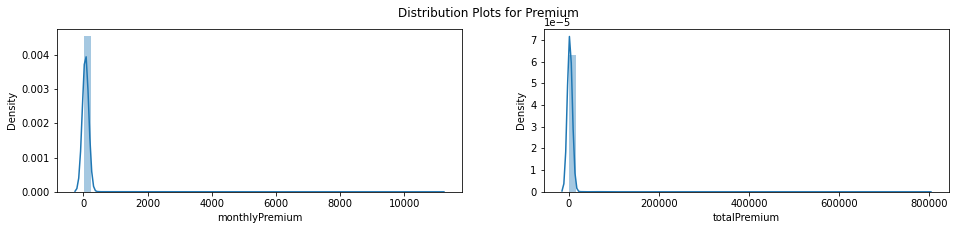

Data is very skewed..


In [1930]:
# Visualise the highlighted columns' outliers
plt.figure(figsize=(16,3))
plt.subplot(1,2,1)
sns.distplot(df['monthlyPremium'])
plt.subplot(1,2,2)
sns.distplot(df['totalPremium'])
plt.suptitle('Distribution Plots for Premium')
plt.show()

print('Data is very skewed..')

In [1931]:
# Perform inter quartile range filtering to new upper lims
premiums = ['monthlyPremium', 'totalPremium']

for i in premiums:
    # Get iqr
    q75, q23 = np.percentile(df[i], [75,25])
    iqr = q75 - q23

    upper_limit = q75 + 1.5 * iqr
    lower_limit = q23 - 1.5 * iqr

    # slice the df
    df = df[df[i] < upper_limit]

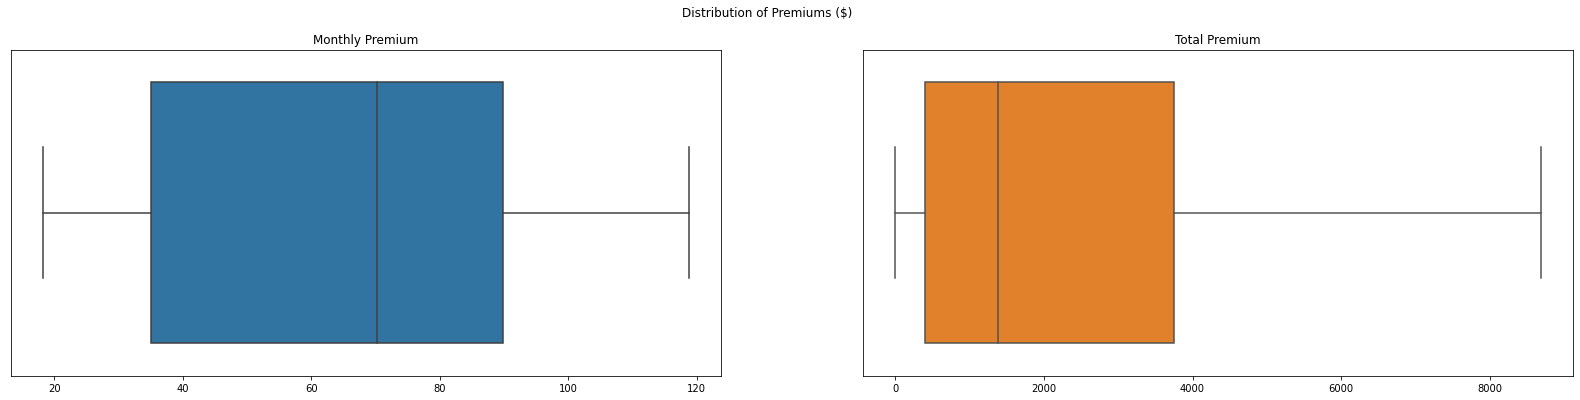

Data is not skewed anymore!


In [1932]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (28,6))
sns.boxplot(df.monthlyPremium, orient= 'h', ax = ax1, color = 'tab:blue')
sns.boxplot(df.totalPremium, orient= 'h', ax = ax2, color = 'tab:orange')

fig.suptitle('Distribution of Premiums ($)')
ax1.set_title('Monthly Premium')
ax1.set_yticks([])
ax2.set_title('Total Premium')
ax2.set_yticks([])
plt.show()

print('Data is not skewed anymore!')

In [1933]:
# Check NA fields
df.isna().sum().sort_values(ascending=False)

healthRiders                1965
premiumFrequency             113
gender                       111
is45OrOlder                   96
insuree#                       0
isMarried                      0
hasKids                        0
insuredMonths                  0
termLifeInsurance              0
multipleTermLifePolicies       0
healthInsurance                0
eStatements                    0
monthlyPremium                 0
totalPremium                   0
renewal                        0
dtype: int64

In [1934]:
# Value counts of all fields with NA
for i in df.columns[df.isnull().any()]:
    print(df[i].value_counts())

M    2695
F    2647
Name: gender, dtype: int64
0.0    4489
1.0     868
Name: is45OrOlder, dtype: int64
3,4        470
2,3,4      428
1,2,3,4    372
2          300
1          276
1,2        245
3          236
4          231
1,3,4      225
2,3        139
2,4        132
1,2,4      130
1,2,3      124
1,4         94
1,3         86
Name: healthRiders, dtype: int64
1.0     2930
12.0    1298
3.0     1112
Name: premiumFrequency, dtype: int64


In [1935]:
### Dealing with NA Values
df = df.copy()

# Gender: Remove all NAs as there is no way for us to fill an arbitrary gender
df = df[df.gender.notna()]

# is45OrOlder: Remove all NAs as there is no way for us to fill an arbitrary age
df = df[df.is45OrOlder.notna()]

# healthRiders: change all values to 0 as there may be people with policies without riders
df.healthRiders.loc[df.healthRiders.isna()] = 0

# premiumFrequency: change all values to 0 as premium can be fully paid
df.premiumFrequency.loc[df.premiumFrequency.isna()] = 0

df.head(2)

,insuree#,gender,is45OrOlder,isMarried,hasKids,insuredMonths,termLifeInsurance,multipleTermLifePolicies,healthInsurance,healthRiders,premiumFrequency,eStatements,monthlyPremium,totalPremium,renewal
0,1,F,0.0,Yes,Yes,23,Yes,No,No,0,12.0,Yes,19.65,451.55,Y
1,2,F,1.0,No,No,42,Yes,Yes,Class A,3,1.0,Yes,84.65,3541.35,N


In [1936]:
# Check NA fields
df.isna().sum().sort_values(ascending=False)

insuree#                    0
gender                      0
is45OrOlder                 0
isMarried                   0
hasKids                     0
insuredMonths               0
termLifeInsurance           0
multipleTermLifePolicies    0
healthInsurance             0
healthRiders                0
premiumFrequency            0
eStatements                 0
monthlyPremium              0
totalPremium                0
renewal                     0
dtype: int64

# 3 - Visualisations: Cross sections of data

Average number of riders per customer: 1.3870783304745569


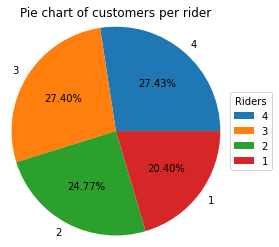

The pie chart shows that the most popular riders among customers are 3 and 4.


In [1937]:
### Q1. 

## Average number of riders per customer
def count_riders(x):
    if isinstance(x, str) == True:
        return x.count(',')+1
    else:
        if x == 0:
            return 0
        return 1
df['count_riders'] = df.healthRiders.apply(lambda x: count_riders(x))
print('Average number of riders per customer: ' + str(df.count_riders.mean()))

## Most popular riders
rider_split_ = []
for i in range(df.count_riders.max()):
    rider_split_.append('rider_split_' +str(i))

# create a split for each unique rider, filters can be added to split_w_filters list for later visualisation
df[rider_split_] = df.healthRiders.str.split(',', expand = True) 
filters = ['is45OrOlder', 'gender', 'isMarried', 'hasKids', 'termLifeInsurance', 'multipleTermLifePolicies', 'healthInsurance', 'premiumFrequency' ]
split_w_filters = filters + rider_split_ 

# Add in age for filter and melt df 
split_df = df[split_w_filters] 
riders_df =  pd.melt(split_df, id_vars = filters, value_vars = rider_split_)

# Create Pie chart for percentage of customers per rider.
riders, cust_per_rider = riders_df.value.value_counts().keys().tolist(), riders_df.value.value_counts().tolist()

plt.pie(cust_per_rider, 
            labels = riders,
            autopct= '%1.2f%%',
            radius = 1.2)
            
plt.title('Pie chart of customers per rider')

plt.legend(title="Riders",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()
print('The pie chart shows that the most popular riders among customers are 3 and 4.')


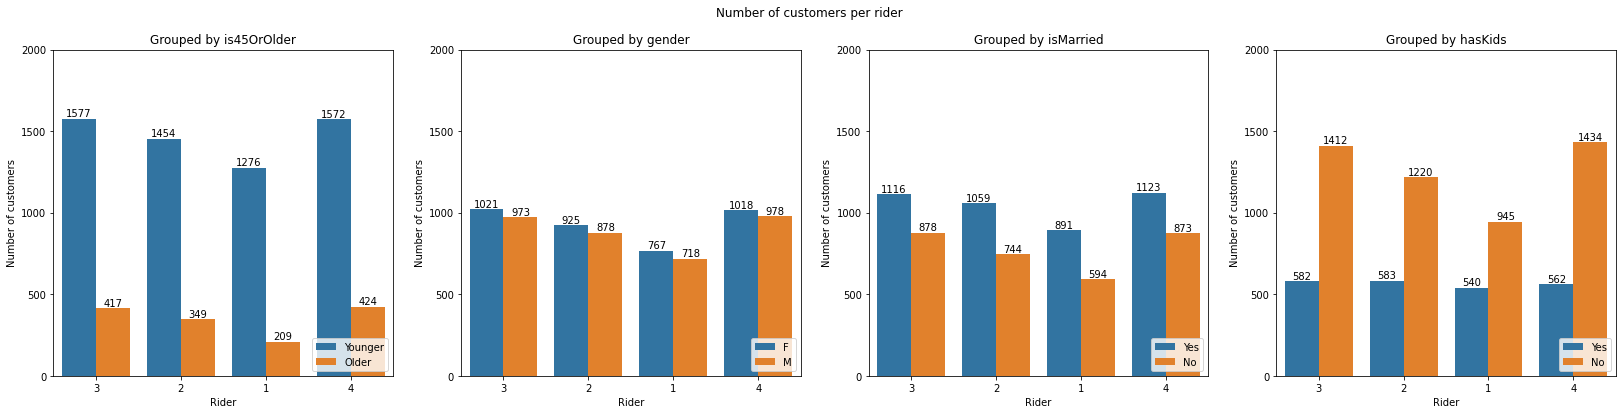

The countplot grouping the customers by age shows that the most popular riders among older people is rider 4.
------
The countplot grouping the customers by gender shows that the choice of riders between both genders are similar
------
Customers who are married tend to purchase rider 2 more, indicating that it is a marriage oriented rider.
------
Interestingly, Customers who have kids tend to purchase rider 2 and rider 1 more proportionately, indicating that 1 may be a child oriented rider.


In [1938]:
### Q2.1

# Drilling down to customer inherent variables: Age, Gender, Marital status and Children.
customer_filters = filters[0:4]

# Visualising factors on rider purchase. 
riders_df['is45OrOlder'] = riders_df.is45OrOlder.apply(lambda x: 'Older' if x == 1 else 'Younger')

# Plotting countplots for each filter (Age, gender, etc.)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (28,6))

# sns.countplot(x = riders_df['value'], dodge = False, ax = ax1)
axes = [ax1, ax2, ax3, ax4]

for i in range(len(customer_filters)):
    sns.countplot(x = riders_df['value'], hue = riders_df[customer_filters[i]], dodge = True, ax = axes[i])
    axes[i].bar_label(axes[i].containers[0])
    axes[i].bar_label(axes[i].containers[1])
    axes[i].set_yticks([0,500,1000,1500,2000])
    axes[i].legend(loc= 'lower right')
    axes[i].set_xlabel('Rider')
    axes[i].set_ylabel('Number of customers')
    axes[i].set_title('Grouped by ' +str(customer_filters[i]))


plt.suptitle('Number of customers per rider')

plt.show()

print('The countplot grouping the customers by age shows that the most popular riders among older people is rider 4.')
print('------')
print('The countplot grouping the customers by gender shows that the choice of riders between both genders are similar')
print('------')
print('Customers who are married tend to purchase rider 2 more, indicating that it is a marriage oriented rider.')
print('------')
print('Interestingly, Customers who have kids tend to purchase rider 2 and rider 1 more proportionately, indicating that 1 may be a child oriented rider.')

# IMPORTANT: IF ERROR IS ENCOUNTERED, PRESS RUN ALL, DO NOT RUN BY CELL.

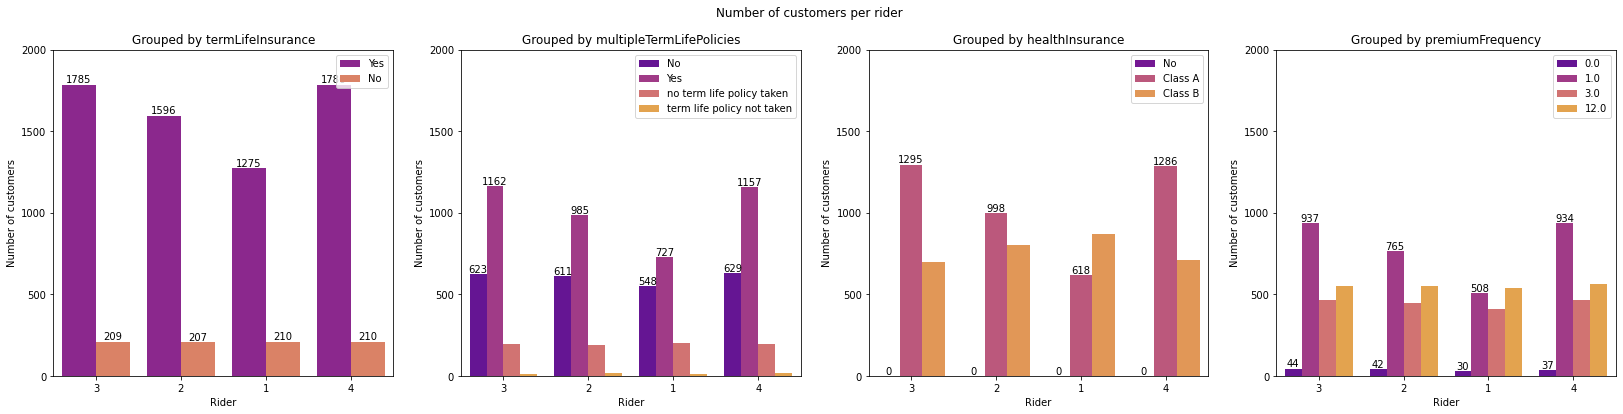

These countplots clue us in to the structure of products: riders 4, 3 and 2 are most popularly sought by customers with term life products
------
Customers with class B health insurance are more likely to purchase rider 1 and 2, whereas class A health insurance holders tend to purchase rider 3 and 4 more
------
From the chart of premium frequency, most customers who purchase a given rider would chose to pay premiums on a monthly basis.


In [1939]:
### Q2.2

# Drilling down to product inherent variables: 'termLifeInsurance', 'multipleTermLifePolicies', 'healthInsurance', 'premiumFrequency' 
product_filters = filters[4:]

# Plotting countplots for each filter (Age, gender, etc.)
fig2, (ax5, ax6, ax7, ax8) = plt.subplots(1,4, figsize = (28,6))

# sns.countplot(x = riders_df['value'], dodge = False, ax = ax1)
axes = [ax5, ax6, ax7, ax8]

for i in range(len(product_filters)):
    sns.countplot(x = riders_df['value'], hue = riders_df[product_filters[i]], dodge = True, ax = axes[i], palette= 'plasma') # I used plasma so its easier to see 4 groupings per patch
    axes[i].bar_label(axes[i].containers[0])
    axes[i].bar_label(axes[i].containers[1])
    axes[i].set_yticks([0,500,1000,1500,2000])
    axes[i].legend(loc= 'upper right')
    axes[i].set_xlabel('Rider')
    axes[i].set_ylabel('Number of customers')
    axes[i].set_title('Grouped by ' +str(product_filters[i]))


plt.suptitle('Number of customers per rider')

plt.show()

print('These countplots clue us in to the structure of products: riders 4, 3 and 2 are most popularly sought by customers with term life products')
print('------')
print('Customers with class B health insurance are more likely to purchase rider 1 and 2, whereas class A health insurance holders tend to purchase rider 3 and 4 more')
print('------')
print('From the chart of premium frequency, most customers who purchase a given rider would chose to pay premiums on a monthly basis.')

# 4 - Data Pre-processing for predictions

In [1940]:
# Create new clean df for predictions
pred_df = df.copy()

# Remove all rider type columns but keep count of rider as deeper analysis of riders above. 
pred_df = pred_df.drop('healthRiders', axis = 1)
pred_df = pred_df.iloc[:, :-4]

pred_df.renewal = pred_df.renewal.apply(lambda x: 1 if x.lower() == 'y' else 0)

In [1941]:
X_df = pred_df.drop('renewal', axis = 1)
y_df = pred_df.renewal

# I did train test split early to prevent data leakage when dealing correlation -> its a waste of time but its conceptually sound (but can be debated)
X_train, X_test, y_train, y_test = train_test_split(X_df , y_df, test_size = 0.33, random_state= 99)

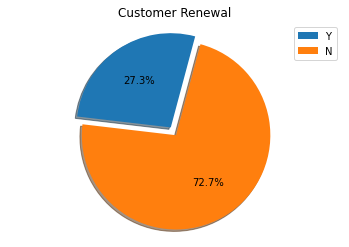

Majority (73.2%) of customers renew their policies.


In [1942]:
# Visualising the renewal rate in training set
renew_counts = y_train.value_counts()
sizes = [renew_counts[0], renew_counts[1]]
labels='Y','N'
explode = (0, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode,autopct='%1.1f%%',shadow=True, startangle=75 )
ax1.axis('equal') 
ax1.set_title("Customer Renewal")
ax1.legend(labels)
plt.show()

print('Majority (73.2%) of customers renew their policies.')

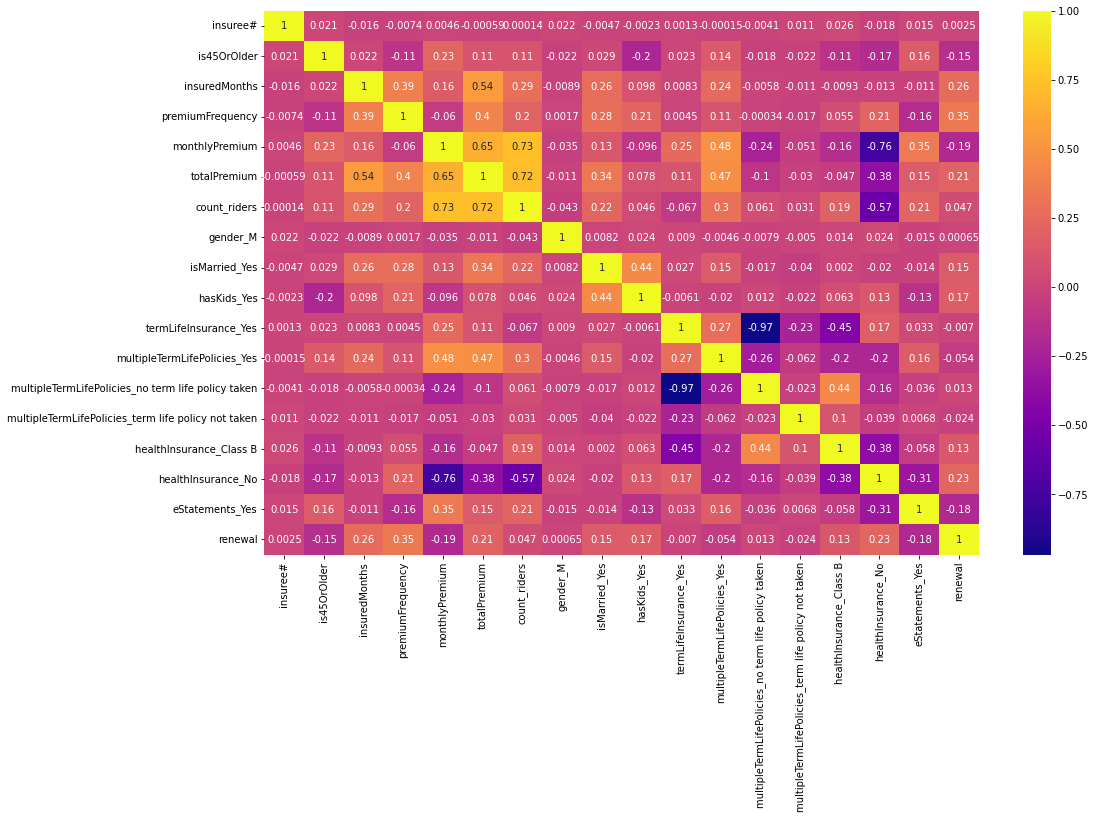

Heatmap of correlation depicts relationships that are intuitive. For example:
-----
Total Premium is positively correlated (0.54) to insured months.
-----
Number of riders is strongly positively correlated (0.73) to monthly premiums (ie. customers pay more for riders)
-----
Term life insurance has strong negative correlation (-0.97) against having non-multiple term life policies, such that a given person with a term life policy is likely to have multiple term life policies.


In [1943]:
# One hot encoding (k-1) for categorical variables
categorical_fields = get_cat_fields(X_train)
X_train_dummies= pd.get_dummies(X_train, columns = categorical_fields , drop_first= True) # Create dummies to find correlation between variables
X_test_dummies= pd.get_dummies(X_test, columns = categorical_fields , drop_first= True)

# Keep a copy of the unscaled features using the ".copy()" method, and name them 'X_train_unscale', 'X_val_unscale', and 'X_test_unscale', respectively
X_train_unscale,  X_test_unscale = X_train.copy(), X_test.copy()

# Scale 'X_train', 'X_val', and 'X_test' data using the mean and standard deviation of the training set. 
X_test=(X_test_dummies-X_train_dummies.mean())/X_train_dummies.std()
X_train=(X_train_dummies-X_train_dummies.mean())/X_train_dummies.std()

train_df = pd.concat([X_train, y_train], axis = 1)
test_df = pd.concat([X_test, y_test], axis = 1)

# Correlation between variables
plt.figure(figsize = (16, 10))
sns.heatmap(train_df.corr(), annot = True, cmap="plasma")
plt.show()

print('Heatmap of correlation depicts relationships that are intuitive. For example:')
print('-----')
print('Total Premium is positively correlated (0.54) to insured months.')
print('-----')
print('Number of riders is strongly positively correlated (0.73) to monthly premiums (ie. customers pay more for riders)')
print('-----')
print('Term life insurance has strong negative correlation (-0.97) against having non-multiple term life policies, such that a given person with a term life policy is likely to have multiple term life policies.')

# 5 - Comparing Prediction Models

Classification Models to compare
- 
- Logistic Regression
- Decision Tree
- Naive Bayes Classifier
- Ada Boost Classifier
- Gradient Boost Classifier

# First metric: Accuracy

In [1944]:
# split the sets back again D:
X_train, y_train = train_df.drop('renewal', axis = 1), train_df.renewal
X_test, y_test =  test_df.drop('renewal', axis = 1), test_df.renewal

In [1945]:
# Defining the modelling function
def modeling(alg, alg_name, params={}):
    model = alg(**params) #Instantiating the algorithm class and unpacking parameters if any
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #Performance evaluation
    def print_scores(alg, y_true, y_pred):
        print(alg_name)
        acc_score = accuracy_score(y_true, y_pred)
        print("accuracy: ",acc_score)
        pre_score = precision_score(y_true, y_pred)
        print("precision: ",pre_score)
        rec_score = recall_score(y_true, y_pred)                            
        print("recall: ",rec_score)
        f_score = f1_score(y_true, y_pred, average='weighted')
        print("f1_score: ",f_score)

    print_scores(alg, y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    #Create the Confusion Matrix Display Object(cmd_obj). 
    cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['Renewed', 'Not renewed'])

    #The plot() function has to be called for the sklearn visualization
    cmd_obj.plot()

    #Use the Axes attribute 'ax_' to get to the underlying Axes object.
    #The Axes object controls the labels for the X and the Y axes. It also controls the title.
    cmd_obj.ax_.set(
                    title='Confusion Matrix', 
                    xlabel='Predicted Renewal', 
                    ylabel='Actual Renewal')
    #Finally, call the matplotlib show() function to display the visualization of the Confusion Matrix.
    plt.show()
    
    return model

Logistic Regression
accuracy:  0.8071593533487298
precision:  0.8614685844057532
recall:  0.8828549262994569
f1_score:  0.8047285787167011


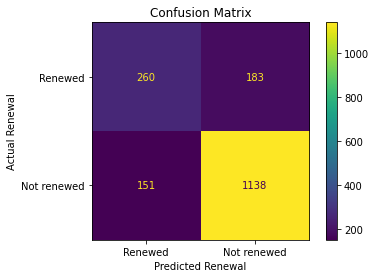

In [1946]:
# Logistic regression
log_model = modeling(LogisticRegression, 'Logistic Regression')

Decision Tree Classification
accuracy:  0.7199769053117783
precision:  0.8305921052631579
recall:  0.7835531419705197
f1_score:  0.7265545417844685


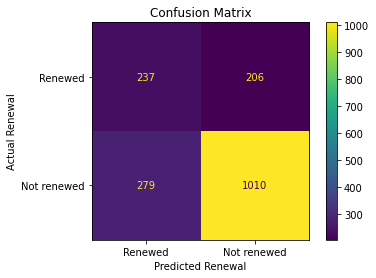

In [1947]:
# Decision tree
dt_model = modeling(DecisionTreeClassifier, "Decision Tree Classification")

Naive Bayes Classification
accuracy:  0.7118937644341802
precision:  0.9089026915113871
recall:  0.6811481768813034
f1_score:  0.7297456470323209


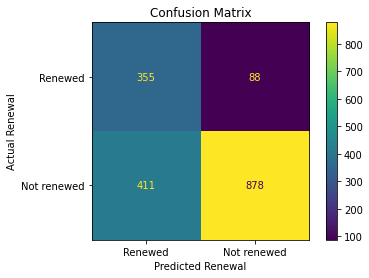

In [1948]:
# Naive bayes 
nb_model = modeling(GaussianNB, "Naive Bayes Classification")

Ada Boost Classifier
accuracy:  0.7938799076212472
precision:  0.8541033434650456
recall:  0.8719937936384794
f1_score:  0.791708719547153


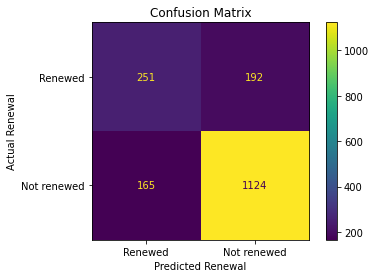

In [1949]:
# Ada Boost Classifier
ad_model=modeling(AdaBoostClassifier, "Ada Boost Classifier")

Gradient Boosting Classifier
accuracy:  0.8042725173210161
precision:  0.856071964017991
recall:  0.8859581070597362
f1_score:  0.8007149941130213


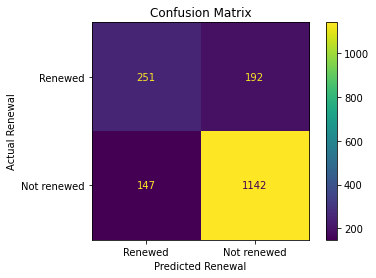

In [1950]:
# Gradient Boosting Classifier
gbm_model=modeling(GradientBoostingClassifier, "Gradient Boosting Classifier")

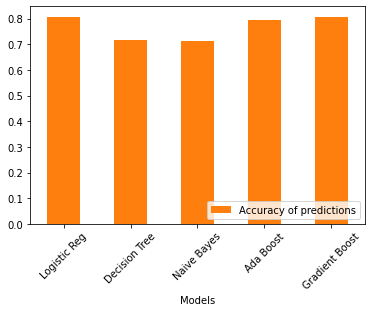

Most accurate models are logistic regression and gradient boost models, with 80.7% accuracy and 80.3% accuracy respectively


In [1951]:
#Showing the accuracy of our models in the form of bar plots
results = pd.DataFrame({'Models':['Logistic Reg', 'Decision Tree', 'Naive Bayes', 'Ada Boost', 'Gradient Boost'], 'Accuracy of predictions':[0.8071593533487298, 0.7176674364896074, 0.7118937644341802, 0.7938799076212472, 0.8048498845265589]})
ax = results.plot.bar(x='Models', y='Accuracy of predictions', rot=45, color = 'tab:orange')
plt.legend(loc = 'lower right')
plt.show()

print('Most accurate models are logistic regression and gradient boost models, with 80.7% accuracy and 80.3% accuracy respectively')

# Second Metric: AUC

In [1952]:
def get_AUC(alg, params={}):
    model = alg(**params) #Instantiating the algorithm class and unpacking parameters if any
    model.fit(X_train, y_train)   
    ###########
    # Plot the ROC curve of a given classifier and the data to evaluate on. Also, calculate the AUC measure.
    # Input: Model
    # Output: The AUC measure
    ###########
    # Get the appropriate feature and outcome data    
    X,y, _ = X_test, y_test, X_test_unscale
    
    # Get the predicted probablities from the current model and from random predictions
    model_prob = model.predict_proba(X)
    model_prob = model_prob[:, 1]
    ns_prob=[0 for _ in range(len(y))]
    
    # Get the AUC scores
    ns_auc=roc_auc_score(y, ns_prob)
    model_auc = roc_auc_score(y,model_prob)
    
    return model_auc

In [1953]:
auc_lr = get_AUC(LogisticRegression)
auc_dt = get_AUC(DecisionTreeClassifier)
auc_nb = get_AUC(GaussianNB)
auc_ab = get_AUC(AdaBoostClassifier)
auc_gb = get_AUC(GradientBoostingClassifier)

auc_lst = [auc_lr, auc_dt, auc_nb, auc_ab, auc_gb]

print(auc_lst)

[0.834447407915913, 0.6528517915965445, 0.8046221982498201, 0.8227491869911581, 0.829975640381278]


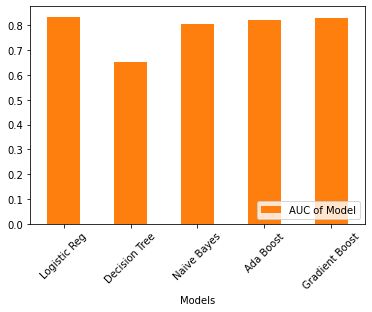

Model with highest AUC is Logistic Regression at 0.834.


In [1954]:
results2 = pd.DataFrame({'Models':['Logistic Reg', 'Decision Tree', 'Naive Bayes', 'Ada Boost', 'Gradient Boost'], 'AUC of Model': auc_lst})
ax10 = results2.plot.bar(x='Models', y='AUC of Model', rot=45, color = 'tab:orange')
plt.legend(loc = 'lower right')
plt.show()

print('Model with highest AUC is Logistic Regression at 0.834.')

Thus, we will select **logistic regression** as the model of choice, as it has the highest accuracy and highest AUC.

# 6 - Finding features that affect Renewals

# Correlation of feature selection

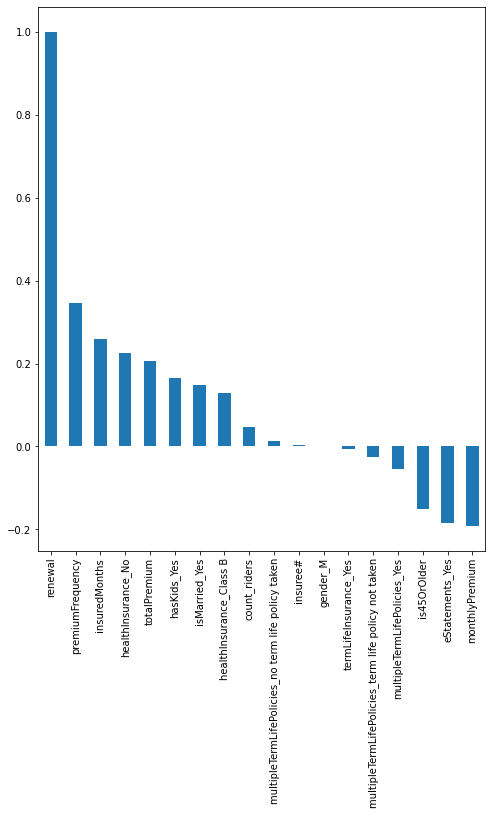

By correlation alone, factors that most likely affect renewals are Premium Frequency, Number of months insured and whether or not they have a health insurance policy.


In [1955]:
# Show which variables are most correlated to renewal
plt.figure(figsize=(8,10))
train_df.corr()['renewal'].sort_values(ascending = False).plot(kind='bar', color = 'tab:blue')
plt.show()
print('By correlation alone, factors that most likely affect renewals are Premium Frequency, Number of months insured and whether or not they have a health insurance policy.')

# Regularisation for feature selection

In [1956]:
# L1 for feature selection

# Create range of lambda values
LAMBDA = np.arange(5,155, 10)

Maximum point for test (45, 0.8340455004754591)


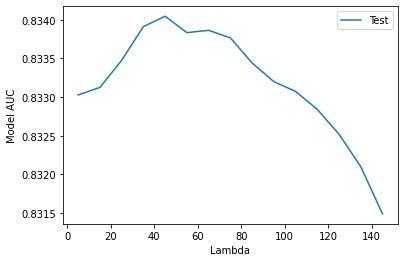

Optimal lambda is 45 obtaining best AUC of 0.834


In [1957]:
def simplified_AUC(model):
    # Get the appropriate feature and outcome data    
    X,y, _ = X_test, y_test, X_test_unscale
    
    # Get the predicted probablities from the current model and from random predictions
    model_prob = model.predict_proba(X)
    model_prob = model_prob[:, 1]
    ns_prob=[0 for _ in range(len(y))]
    
    # Get the AUC scores
    ns_auc=roc_auc_score(y, ns_prob)
    model_auc = roc_auc_score(y,model_prob)
    
    return model_auc


def plot_auc_l1(LAMBDA):
    auc_lst_test = []

    for lamb in LAMBDA:
        #Create an instance of logisticregression named lgstc_reg_l1
        lgstc_reg_l1 =  LogisticRegression(penalty="l1",solver="liblinear", C = 1/lamb)

        # Fit logististic regression to training set
        lgstc_reg_l1.fit(X_train, y_train) # fit training data on logistic regression

        # Fit logististic regression to training set
        auc_lst_test.append(simplified_AUC(lgstc_reg_l1))


    # find max points 
    def find_max_point(x,y):
        max_x, max_y = x[np.argmax(y)] , max(y)
        return (max_x, max_y)

    # max point for test
    print("Maximum point for test " + str(find_max_point(LAMBDA, auc_lst_test)))

    # Plot 2 in 1
    plt.plot(LAMBDA, auc_lst_test, label = "Test")
    plt.xlabel("Lambda")
    plt.ylabel("Model AUC")
    plt.legend()
    plt.show()


plot_auc_l1(LAMBDA)

print('Optimal lambda is 45 obtaining best AUC of 0.834')

In [1958]:
lgstc_reg_l1_best =  LogisticRegression(penalty="l1",solver="liblinear", C = 1/45)
lgstc_reg_l1_best.fit(X_train, y_train)

features = X_train.columns.tolist()
coefs = lgstc_reg_l1_best.coef_[0].tolist()

important_coefs = pd.DataFrame(zip(features, coefs), columns = ['Feature', 'Coef'])
important_coefs = important_coefs.loc[(important_coefs.Coef != 0)]
important_coefs.sort_values(by = 'Coef',ascending = False)

,Feature,Coef
2,insuredMonths,1.111203
15,healthInsurance_No,0.593818
3,premiumFrequency,0.468225
14,healthInsurance_Class B,0.374603
9,hasKids_Yes,0.043359
10,termLifeInsurance_Yes,0.042123
1,is45OrOlder,-0.095588
11,multipleTermLifePolicies_Yes,-0.116546
16,eStatements_Yes,-0.117500


# 7 - Conclusion

By building a Regularised model:
- We can find the optimal lambda
- We can find the significant features (ie features not reduced to zero through regularization.)

As coefs furthest from 0 are most significant, we can conclude that insured months is the most significant factor in determining renewals, followed by having health insurance.